In [1]:
# Install Packages

import numpy as np
from scipy import stats
import pylab as plt
import torch
import pytorch_lightning as pl
import swyft
import matplotlib.pyplot as plt

import scipy
import time
import seaborn as sns
plt.rc("text", usetex=True)
plt.rc("font", family="Serif")
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

In [2]:
# Define simulator parameters
f_low = 10
f_high = 1024
N_bins = 4096
freq = np.linspace(f_low, f_high, N_bins)
pi = np.pi
sqrt = np.sqrt
H100 = 3.241e-18
h    = 0.679
H0   = h * H100

# Define Simulator
class Simulator(swyft.Simulator):
    def __init__(self, fref, psd, gamma, T_obs, Nbins=len(freq), bounds=None):
        super().__init__()
        self.fref      = fref
        self.psd       = psd
        self.gamma     = gamma
        self.T_obs     = T_obs
        
        self.transform_samples = swyft.to_numpy32
        self.Nbins = Nbins
        self.freq = np.linspace(f_low, f_high, N_bins)
        self.sample_z = swyft.RectBoundSampler([stats.loguniform(1e-12,1e-7), #omega
                                                stats.uniform(0.5,2.5)], #alpha
                                                bounds = bounds) #bounds changes range of the prior

    def psd_interp(self):
        return scipy.interpolate.interp1d(self.psd[:,0], self.psd[:,1])(self.freq)
    
    def gamma_interp(self):
        return scipy.interpolate.interp1d(self.gamma[:, 0], self.gamma[:, 1])(self.freq)
    
    def sigma(self):
        numerator = (20*pi**2*self.freq**3)**2 * self.psd_interp()**2
        denomenator = (3*H0**2)**2 * 8*self.gamma_interp()**2
        T = 1/(self.freq[1]-self.freq[0])
        N = 2*self.T_obs // T - 1
        return np.sqrt(numerator/denomenator/N)
    
    def C_groundtruth(self, z):
        Omega_ref = 10**z[0]
        alpha     = z[1]
        C_hat_ij = Omega_ref * (self.freq/self.fref)**alpha
        return C_hat_ij
    
    def build(self, graph):
        z = graph.node('z', self.sample_z)
        m = graph.node('m', self.C_groundtruth, z)
        x = graph.node("x", lambda m: m + np.random.normal(0, self.sigma()), m)
        #x = graph.node("x", lambda m: m + 0, m) #Ground truth wih sigma noise
        sigma = graph.node('sigma',self.sigma)

In [3]:
# Sample from Simulator

n_samples = 10000
fref = 25
CE_PSD = np.genfromtxt("data/cosmic_explorer_40km_for_paper.txt")
CE_PSD[0, 0]  = 4.99999999999999999
CE_PSD[:, 1] = CE_PSD[:, 1]**2
gamma_HL = np.genfromtxt("data/gamma_HL.txt")
T_obs = 365 * 24 * 3600

sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=None)
obs = sim.sample(conditions = {'z': np.array([5e-8, 2.1])})
samples = sim.sample(n_samples) 
samples['x'] = np.log10(np.abs(samples['x']))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [4]:

import torch.nn as nn
import torch.nn.functional as F


class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # VAE
        self.summarizer =  nn.Sequential(
            nn.Linear(4096, 2048),
            nn.GELU(),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
            nn.Linear(16, 2),
        )


        # Log-ratio estimator with 1 feature (x) and 2 parameters (alpha, omega)
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=1,  # Number of features in compressed x (simulated observation)
            num_params=2,    # Two parameters to infer: alpha and omega
            varnames='z',  # Names of the parameters
            # Number of neural network blocks
        )

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z']), s

In [5]:
def round(obs, bounds=None):
    sim = Simulator(fref, CE_PSD, gamma_HL, T_obs, bounds=bounds)
    #samples = sim.sample(n_samples) 
    samples = sim.sample(10000)
    samples['x'] = np.log10(np.abs(samples['x']))
   

    dm = swyft.SwyftDataModule(samples#, #batch_size = 64
                               )
    trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
    network = Network()
    trainer.fit(network, dm)
    prior_samples = sim.sample(N = 10000, targets = ['z'])
    predictions = trainer.infer(network, obs, prior_samples)
    new_bounds = swyft.collect_rect_bounds(predictions[0], 'z', (2,), threshold = 1e-6)
    return predictions, new_bounds, samples



  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/Users/lexi

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataload

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_467/checkpoints/epoch=1-step=500.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


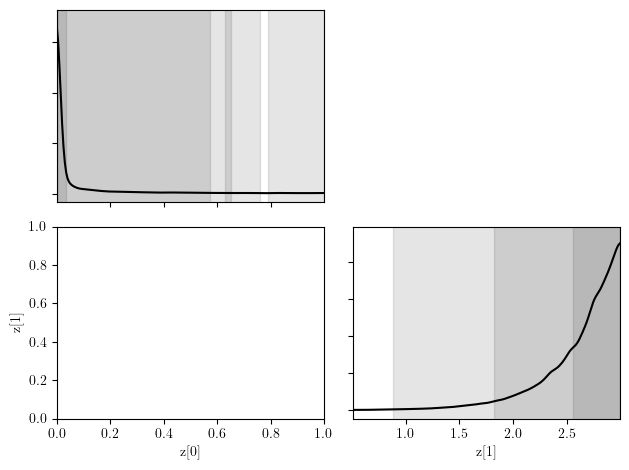

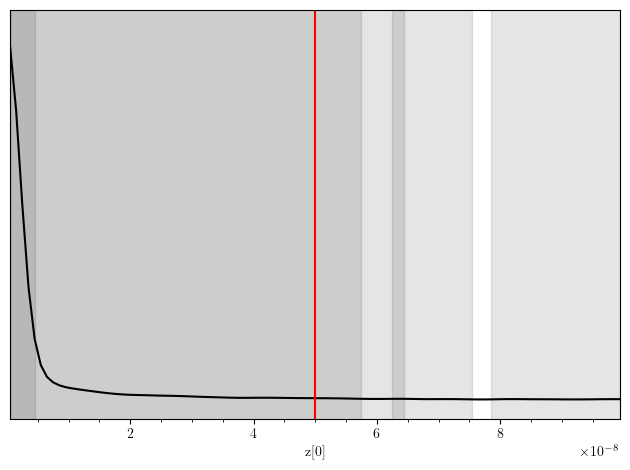

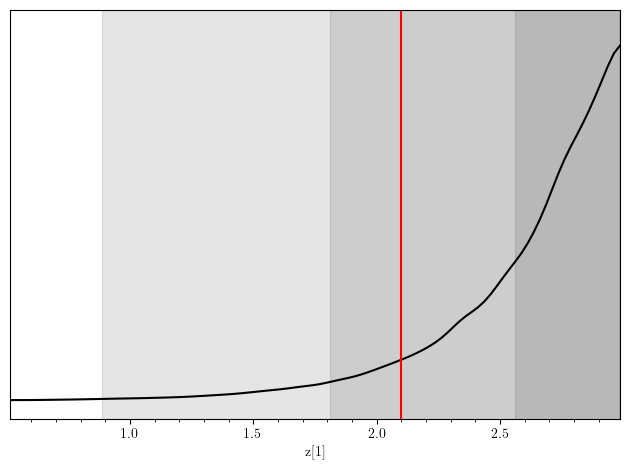

New bounds: tensor([[1.0009e-12, 9.9908e-08],
        [5.0074e-01, 2.9996e+00]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 11.2 M
1 | logratios  | LogRatioEstimator_1dim | 34.8 

Sanity Checking: 0it [00:00, ?it/s]

/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_469/checkpoints/epoch=10-step=2750.ckpt


/Users/lexington/anaconda3/envs/test_env/lib/python3.11/site-packages/swyft/lightning/utils.py:535: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(sel

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

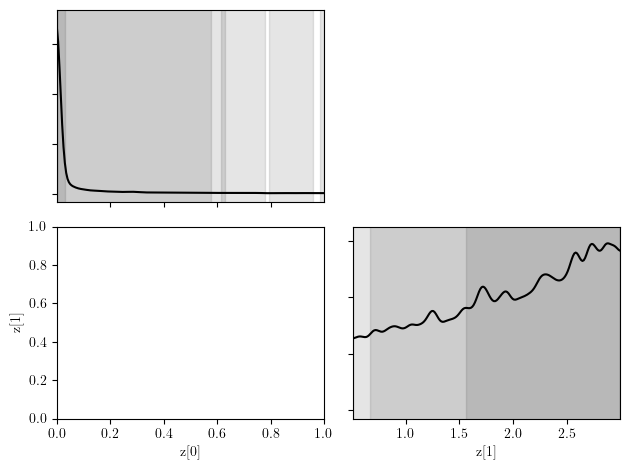

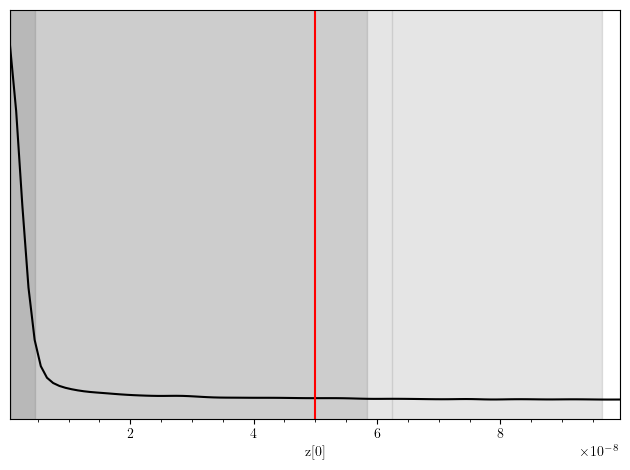

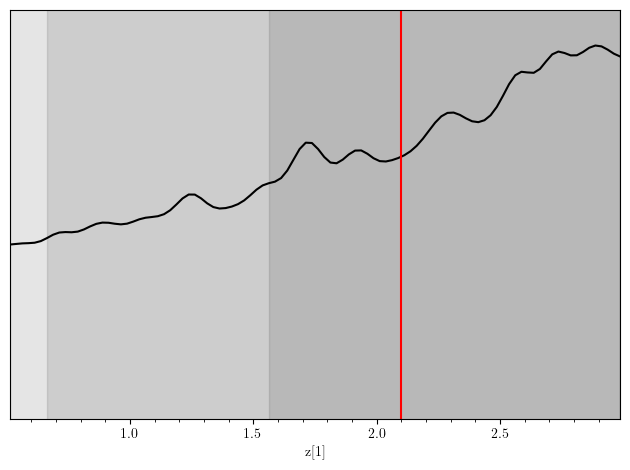

New bounds: tensor([[1.0053e-12, 9.9891e-08],
        [5.0139e-01, 2.9996e+00]], dtype=torch.float64)


  0%|          | 0/10000 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Sequential             | 11.2 M
1 | logratios  | LogRatioEstimator_1dim | 34.8 K
------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
89.578    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/lexington/Documents/GitHub/SBI_SGWB_DSMMA/Lexi/lightning_logs/version_471/checkpoints/epoch=3-step=1000.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

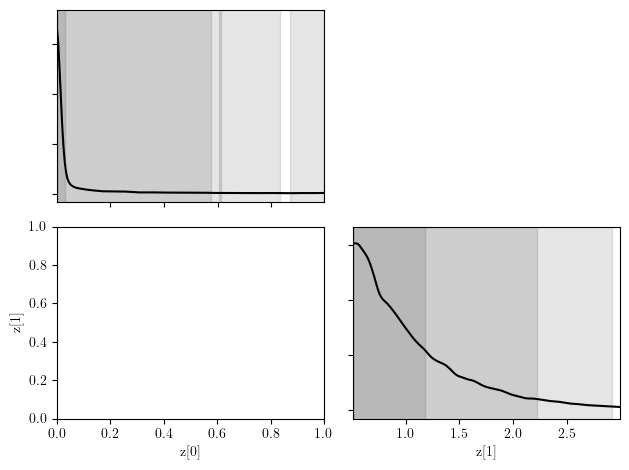

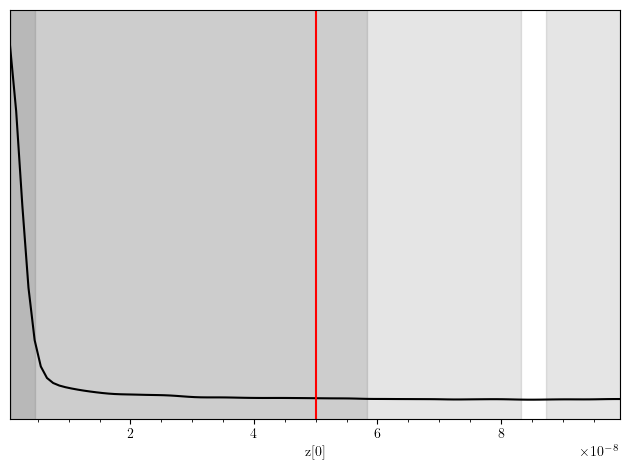

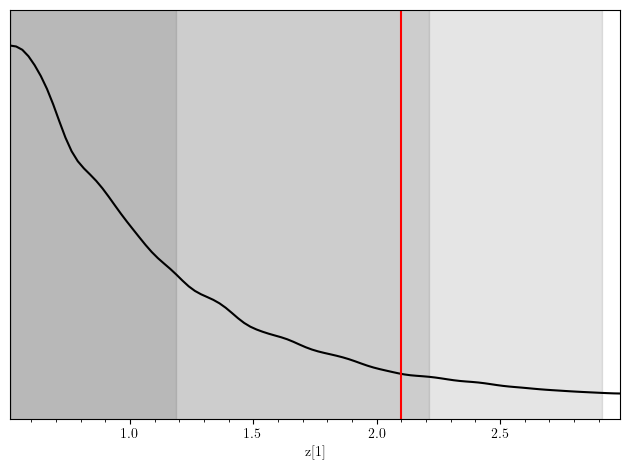

New bounds: tensor([[1.0064e-12, 9.9769e-08],
        [5.0148e-01, 2.9989e+00]], dtype=torch.float64)


In [6]:
bounds = None
prediction_rounds = []
bounds_rounds = []
samples_rounds = []

for n in range(3):
    predictions, bounds, samples = round(obs, bounds = bounds)

    

    swyft.plot_corner(predictions, ['z[0]', 'z[1]'], bins = 200, smooth = 3);
    plt.show()
    swyft.plot_posterior(predictions, 'z[0]', smooth=2);
    plt.axvline(obs['z'][0], color="red")
    plt.show()

    swyft.plot_posterior(predictions, 'z[1]', smooth=2);
    plt.axvline(obs['z'][1], color="red")
    plt.show()

    
    prediction_rounds.append(predictions)
    bounds_rounds.append(bounds)
    samples_rounds.append(samples)
    print("New bounds:", bounds)

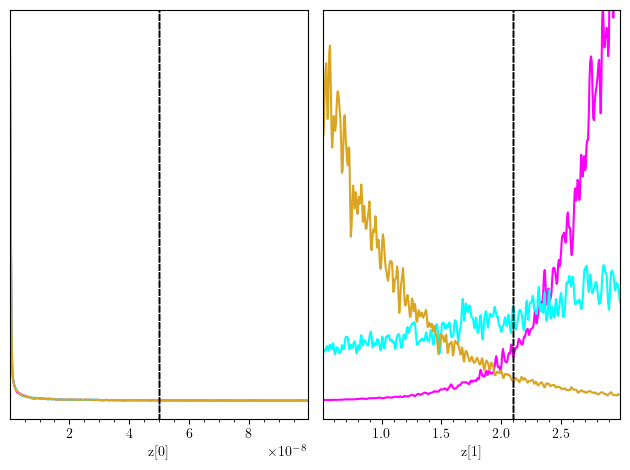

In [7]:
n_rounds = 3
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(n_rounds):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

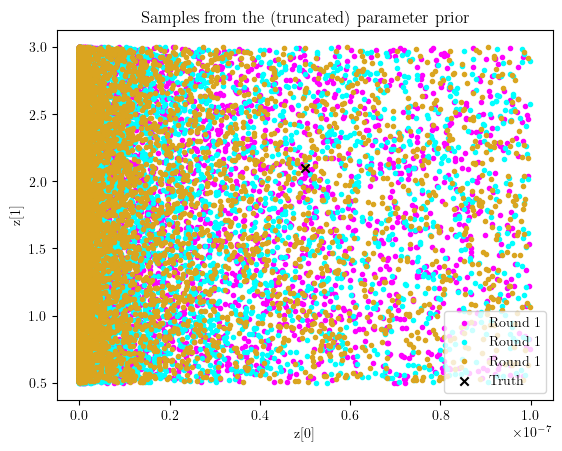

In [8]:
for i in range(n_rounds):

    plt.scatter(samples_rounds[i]['z'][:,0], samples_rounds[i]['z'][:,1], color = colors[i], label = 'Round 1', marker = '.')

plt.scatter(obs['z'][0], obs['z'][1], marker = 'x', color='k', label = 'Truth')
plt.legend()
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.title("Samples from the (truncated) parameter prior");

In [12]:
print(np.asarray(bounds_rounds))

[[[1.00090975e-12 9.99084051e-08]
  [5.00740707e-01 2.99959064e+00]]

 [[1.00533817e-12 9.98910608e-08]
  [5.01394451e-01 2.99955750e+00]]

 [[1.00637868e-12 9.97689327e-08]
  [5.01483381e-01 2.99888945e+00]]]


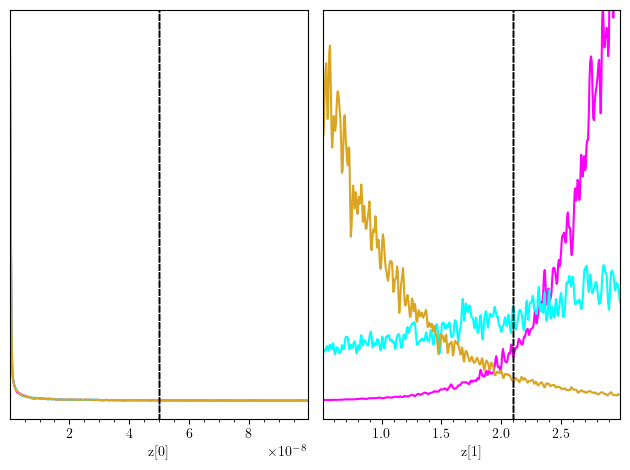

In [13]:
n_rounds = 3
truth = {k: v for k, v in zip(["z[%i]"%i for i in range(2)], obs['z'])}
colors = ['fuchsia', 'cyan', 'goldenrod']
fig = None
for i in range(n_rounds):
    fig = swyft.plot_posterior(prediction_rounds[i], ["z[%i]"%i for i in range(2)], fig=fig, truth=truth, smooth = 1, bins = 400, contours = False, color=colors[i])

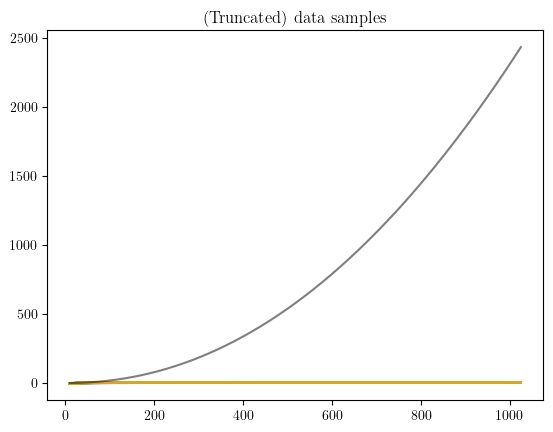

In [14]:
for i in range(0, n_rounds):
    for j in range(50):
        plt.plot(sim.freq, samples_rounds[i]['x'][j], color =colors[i])
plt.plot(sim.freq, obs['x'], color = 'k', alpha = 0.5)
#plt.ylim([-1, 1])
plt.title("(Truncated) data samples");